In [4]:
# Check if GPU is mounted

import torch
x = torch.cuda.is_available()
print(x)

True


In [5]:
# To make sure the dataset is accessable from my server

import sys,os,os.path
os.environ['HTTP_PROXY']="192.168.0.200:7890"
os.environ['HTTPS_PROXY']="192.168.0.200:7890"

import requests
requests.get("http://google.com")

<Response [200]>

In [55]:
from collections import OrderedDict
from typing import List, Tuple, Dict, Optional, Callable, Union
from PIL import Image, ImageEnhance, ImageFilter
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader, Subset, random_split

from collections import OrderedDict

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents, ClientManager
from flwr.server.strategy import Strategy, FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context
from flwr.common import FitRes, Parameters, parameters_to_ndarrays
from flwr.server.client_proxy import ClientProxy

device = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = torch.device(device)  # Try "cuda" to train on GPU
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cuda
Flower 1.13.0 / PyTorch 2.4.1


In [32]:
# Some network, for MNIST dataset
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
def train(net, trainloader, epochs: int, verbose=False, device = DEVICE):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    net.to(device)
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader, device = DEVICE):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    net.to(device)
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [14]:
transform = transforms.ToTensor()
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Split into 4 datasets
NUM_CLIENTS = 4
total_size = len(mnist_dataset)
indices = list(range(total_size))
np.random.shuffle(indices)
split_size = total_size // NUM_CLIENTS
subsets = [Subset(mnist_dataset, indices[i * split_size:(i + 1) * split_size]) for i in range(NUM_CLIENTS)]


# 1. Vanilla dataset
transform_1 = transforms.ToTensor()

# 2. remove all digit '7'
class RemoveLabel7:
    def __call__(self, dataset):
        indices = [i for i, (_, label) in enumerate(dataset) if label != 7]
        return Subset(dataset, indices)

subset_2 = RemoveLabel7()(subsets[1])

# 3. Apply Gaussian Blue
class ApplyGaussianBlur:
    def __init__(self, radius=2):
        self.radius = radius

    def __call__(self, img):
        img = transforms.ToPILImage()(img)
        img = img.filter(ImageFilter.GaussianBlur(self.radius))
        img = transforms.ToTensor()(img)
        return img

transform_3 = ApplyGaussianBlur(radius=1)

# 4. Rotate 45 degree
transform_4 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Lambda(lambda img: img.rotate(45, fillcolor=(0,))),
    transforms.ToTensor()
])

In [15]:
# Build the corresponding loaders
loaders = []
for i, subset in enumerate([subsets[0], subset_2, subsets[2], subsets[3]]):
    train_size = int(0.7 * len(subset))
    val_size = int(0.1 * len(subset))
    test_size = len(subset) - train_size - val_size
    train_subset, val_subset, test_subset = random_split(subset, [train_size, val_size, test_size])

    if i == 2:
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, collate_fn=lambda batch: (torch.stack([transform_3(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, collate_fn=lambda batch: (torch.stack([transform_3(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
        test_loader = DataLoader(test_subset, batch_size=32, shuffle=False, collate_fn=lambda batch: (torch.stack([transform_3(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
    elif i == 3:
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, collate_fn=lambda batch: (torch.stack([transform_4(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, collate_fn=lambda batch: (torch.stack([transform_4(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
        test_loader = DataLoader(test_subset, batch_size=32, shuffle=False, collate_fn=lambda batch: (torch.stack([transform_4(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
    else:
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

    loaders.append((train_loader, val_loader, test_loader))

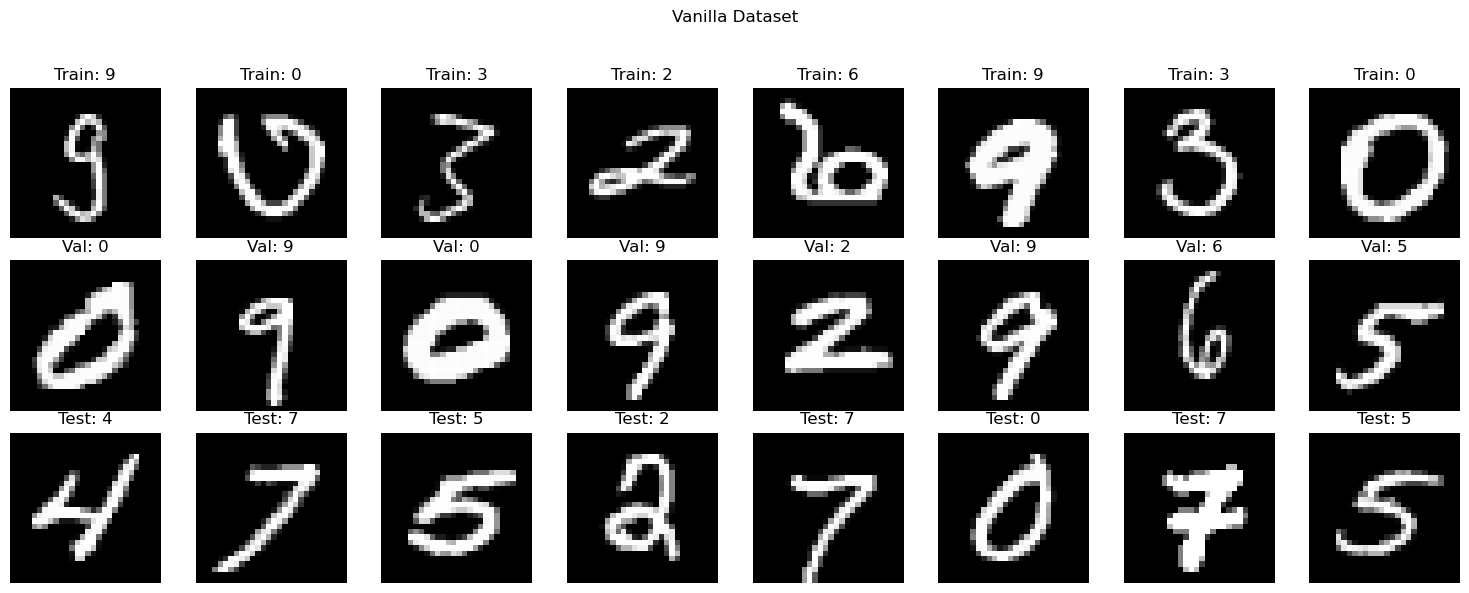

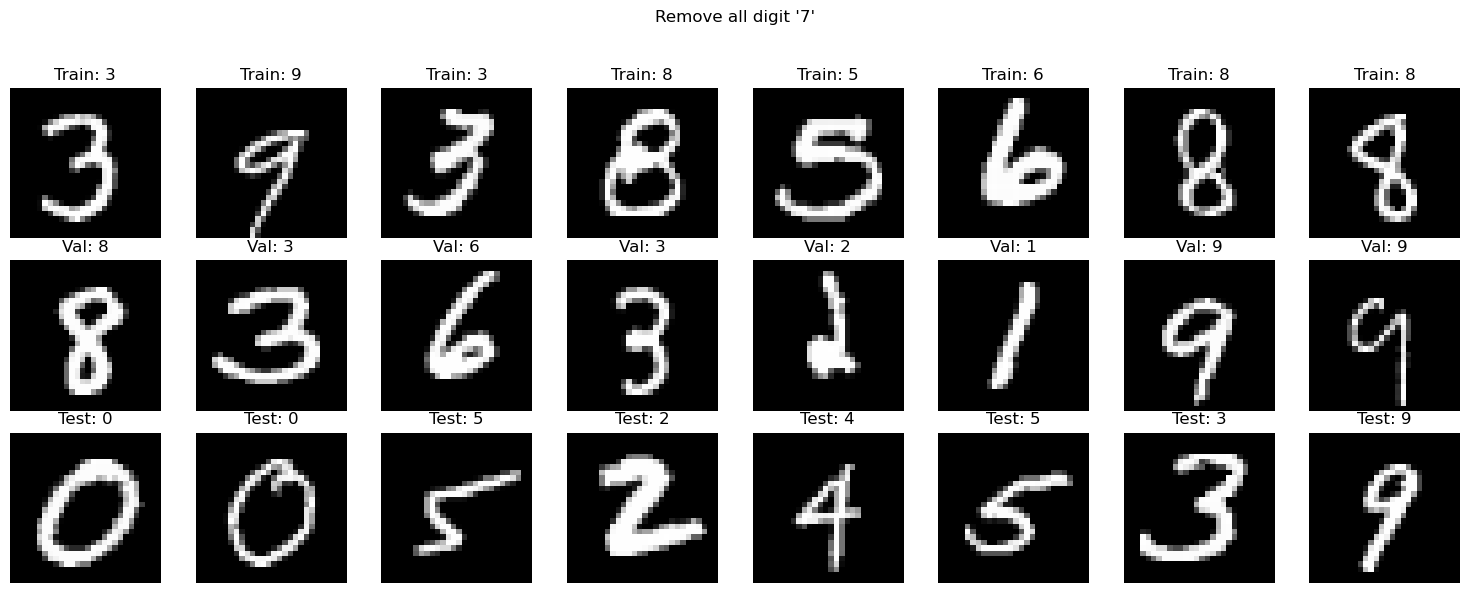

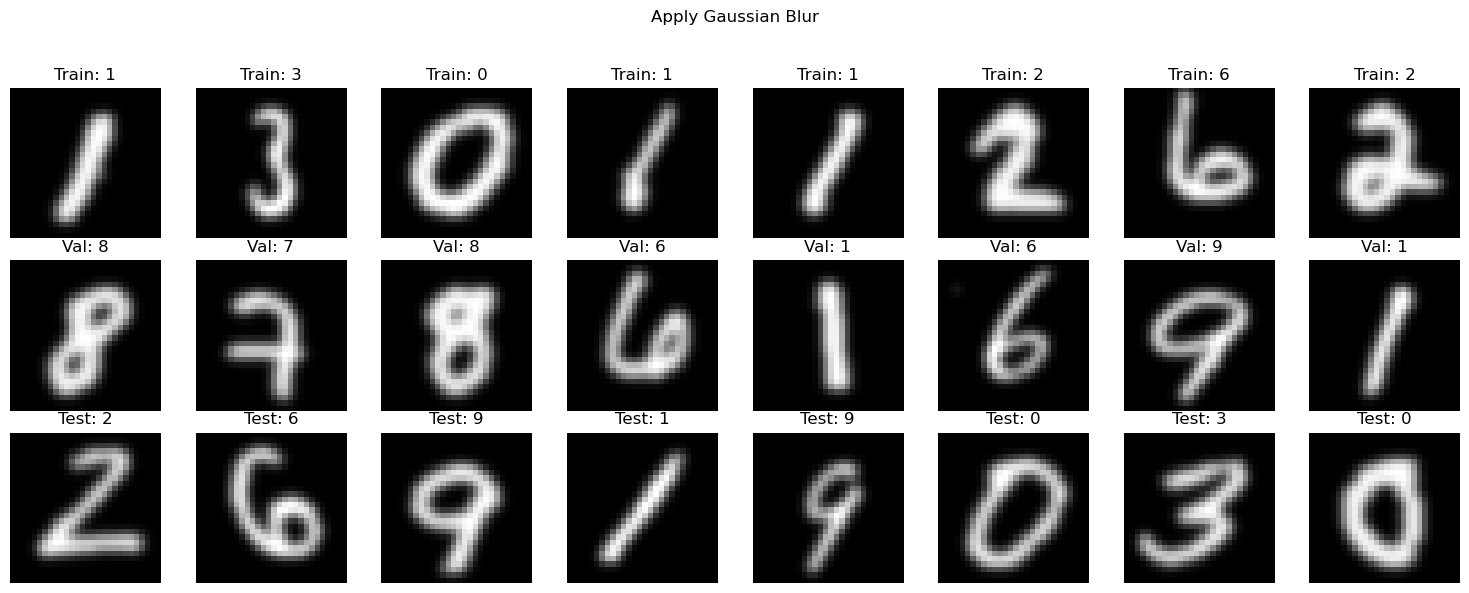

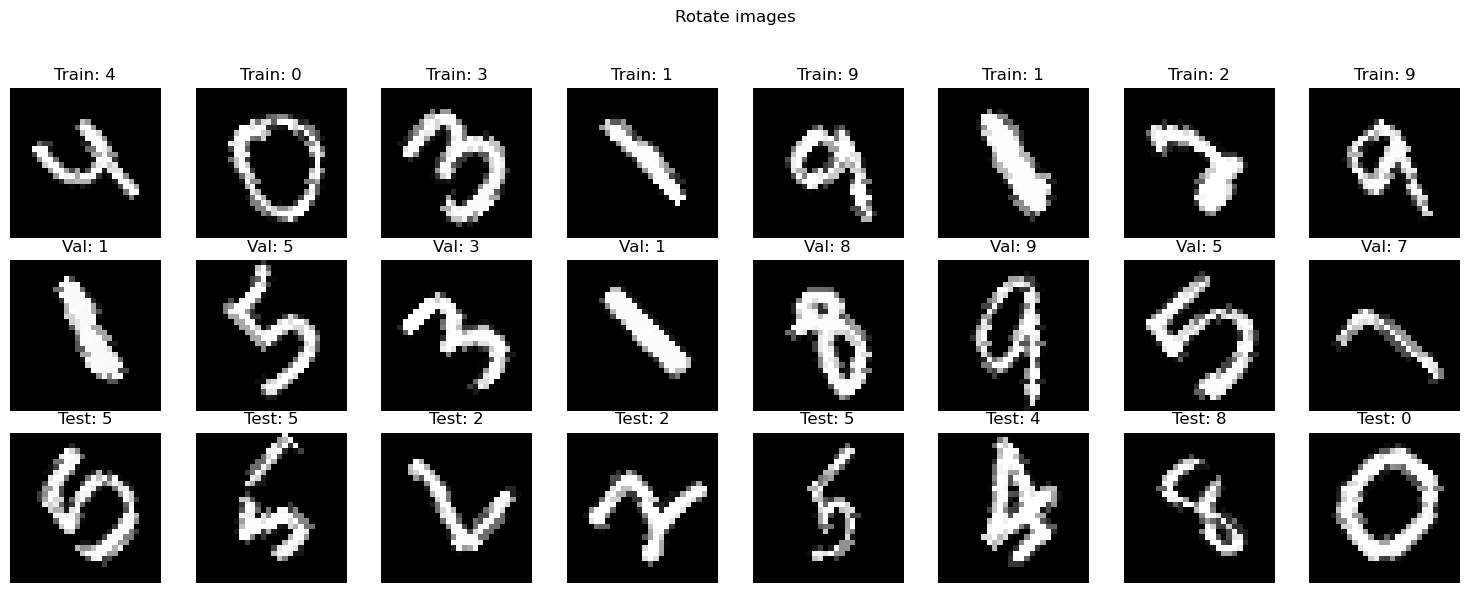

In [16]:
title = ["Vanilla Dataset", "Remove all digit \'7\'", "Apply Gaussian Blur", "Rotate images"]

for client_idx, (train_loader, val_loader, test_loader) in enumerate(loaders):
    fig, axes = plt.subplots(3, 8, figsize=(15, 6))
    fig.suptitle(title[client_idx])
    
    # Train
    for j, (x, y) in enumerate(train_loader):
        if j >= 8:
            break
        axes[0, j].imshow(x[0].squeeze(), cmap='gray')
        axes[0, j].axis('off')
        axes[0, j].set_title(f"Train: {y[0].item()}")
    
    # Validation
    for j, (x, y) in enumerate(val_loader):
        if j >= 8:
            break
        axes[1, j].imshow(x[0].squeeze(), cmap='gray')
        axes[1, j].axis('off')
        axes[1, j].set_title(f"Val: {y[0].item()}")
    
    # Test
    for j, (x, y) in enumerate(test_loader):
        if j >= 8:
            break
        axes[2, j].imshow(x[0].squeeze(), cmap='gray')
        axes[2, j].axis('off')
        axes[2, j].set_title(f"Test: {y[0].item()}")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

In [17]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [18]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader, id_):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.id = id_

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        print(f"{self.id} accuracy: {float(accuracy)}")
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [19]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (MNIST)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data partition
    # Read the node_config to fetch data partition associated to this node
    partition_id = context.node_config["partition-id"]
    trainloader, valloader, _ = loaders[partition_id]

    # Create a single Flower client representing a single organization
    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
    # to convert it to a subclass of `flwr.client.Client`
    return FlowerClient(net, trainloader, valloader, partition_id).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)


In [20]:

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

# The `evaluate` function will be called by Flower after every round
def evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar],
) -> Optional[Tuple[float, Dict[str, Scalar]]]:
    net = Net().to(DEVICE)
    _, _, testloader = loaders[0]
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, testloader)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    return loss, {"accuracy": accuracy}

# Create FedAvg strategy
strategy = FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=4,  # Never sample less than 4 clients for training
    min_evaluate_clients=4,  # Never sample less than 4 clients for evaluation
    min_available_clients=4,  # Wait until all 4 clients are available
    evaluate_metrics_aggregation_fn=weighted_average, # metric aggregation function
    evaluate_fn=evaluate,  # Pass the evaluation function
)

In [21]:


def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour.

    You can use the settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """

    # Configure the server for 5 rounds of training
    config = ServerConfig(num_rounds=5)

    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

In [22]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

In [97]:
# Run simulation
# run_simulation(
#     server_app=server,
#     client_app=client,
#     num_supernodes=NUM_CLIENTS,
#     backend_config=backend_config,
# )

In [99]:
# Wrap the above ugly code of flower client into a class

class FLClient(NumPyClient):
    """A Flower client that holds its own model and training data."""

    def __init__(
        self,
        net: nn.Module,
        trainloader: DataLoader,
        valloader: DataLoader,
        device: torch.device,
        client_id: int,
        epochs: int = 1,
    ):
        super().__init__()
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.device = device
        self.client_id = client_id
        self.epochs = epochs

    def get_parameters(self, config: Dict[str, Scalar]) -> List[np.ndarray]:
        """Return the current local model parameters."""
        return get_parameters(self.net)

    def fit(
        self, parameters: List[np.ndarray], config: Dict[str, Scalar]
    ) -> Tuple[List[np.ndarray], int, Dict[str, Scalar]]:
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, device=self.device, epochs=self.epochs, verbose=False)
        new_params = get_parameters(self.net)
        # Return partition-id in the metrics
        # The simplest way to store the model
        return new_params, len(self.trainloader.dataset), {"partition-id": self.client_id}

    def evaluate(
        self, parameters: List[np.ndarray], config: Dict[str, Scalar]
    ) -> Tuple[float, int, Dict[str, Scalar]]:
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader, self.device)
        print(f"[Client {self.client_id}] Evaluate -> Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
        return float(loss), len(self.valloader.dataset), {"accuracy": float(accuracy)}

class DefaultStrategy(FedAvg):

    # A custom strategy to store all the parameters.
    # https://github.com/adap/flower/issues/487
    # https://flower.ai/docs/framework/how-to-save-and-load-model-checkpoints.html

    def __init__(self, model: type, total_round: int, only_last: bool = True, save_dir: str = "models", *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)

        self.model = model
        self.total_round = total_round
        self.only_last = only_last
        # If you want to map each client ID to a "partition ID" or other info,
        # you can store it here. In a real-world setting you might set it
        # when the client connects, or in simulation it might just be client ID == partition ID.
        self.cid_to_partition = {}


    def aggregate_fit(
        self,
        server_round: int,
        results: list[tuple[ClientProxy, FitRes]],
        failures: list[Union[tuple[ClientProxy, FitRes], BaseException]],
    ) -> tuple[Optional[Parameters], dict[str, Scalar]]:
        """
        Aggregate model weights using weighted average.
        Also save each client's model and the global server model.
        """

        if self.only_last and server_round < self.total_round:
            return super().aggregate_fit(server_round, results, failures)

        # Call aggregate_fit from base class (FedAvg) to aggregate parameters and metrics
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(
            server_round, results, failures
        )

        # 2) For each client which returned FitRes, save the client model
        for (client_proxy, fit_res) in results:
            id_ = fit_res.metrics["partition-id"]

            client_parameters: Optional[Parameters] = fit_res.parameters
            if client_parameters is not None:
                net = self.model()
                print(f"[Round {server_round}] Saving model for client {id_}...")

                # Convert `Parameters` to `list[np.ndarray]`
                client_ndarrays : list[np.ndarray] = parameters_to_ndarrays(
                    client_parameters
                )

                # Convert `list[np.ndarray]` to PyTorch `state_dict`
                params_dict = zip(net.state_dict().keys(), client_ndarrays)
                state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
                net.load_state_dict(state_dict, strict=True)

                # Save the model to disk
                torch.save(net.state_dict(), f"{self.save_dir}/client-{server_round}-{id_}.pth")

        # 3) If `aggregated_parameters` is not None, update the global net and save it
        if aggregated_parameters is not None:
            net = self.model()
            print(f"Saving round {server_round} aggregated_parameters...")

            # Convert `Parameters` to `list[np.ndarray]`
            aggregated_ndarrays: list[np.ndarray] = parameters_to_ndarrays(
                aggregated_parameters
            )

            # Convert `list[np.ndarray]` to PyTorch `state_dict`
            params_dict = zip(net.state_dict().keys(), aggregated_ndarrays)
            state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
            net.load_state_dict(state_dict, strict=True)

            # Save the model to disk
            torch.save(net.state_dict(), f"{self.save_dir}/server-{server_round}.pth")

        return aggregated_parameters, aggregated_metrics


In [124]:
# Use the following class to run the experiment

# You need to provide the following information:
# 1. The Network class (dont instantiate it)
#       (assume we use the same network for all clients and server)
# 2. The list of data loaders for each client,
#       where loaders is a list of loader tuples (train, val, test)
#       i.e. loaders = [ (train_loader_0, val_loader_0, test_loader_0), ... ]
#       NOTE: In fit and evaluate, we ONLY use the train_loader and val_loader,
#             But we ask you to pyt them together for simplicity for any future test use.
#       NOTE: we assume the number of clients == number of data loaders
# 3. Number of clients

# See next block for an example of how to use this class

class FLExperiment:
    """
    A federated learning experiment interface class.

    NOTE: For each client, we now expect a tuple of three DataLoaders:
    (train_loader, val_loader, test_loader).
    """

    def __init__(
        self,
        model_cls: type,
        client_loaders: List[Tuple[DataLoader, DataLoader, DataLoader]],
        num_clients: int,
        device: torch.device = torch.device("cpu"),
        local_epochs: int = 1,
        num_rounds: int = 5,
        # strategy: Optional[Strategy] = None, # Is not supported yet. and may not be needed
    ):
        """
        Args:
            model_cls (type): A PyTorch nn.Module class (not an instance).
                We'll instantiate `model_cls()` for each client and server.
            client_loaders (List[(DataLoader, DataLoader, DataLoader)]):
                A list of (train_loader, val_loader, test_loader) for each client.
            num_clients (int): Number of clients to simulate.
            device (torch.device): CPU or GPU device.
            local_epochs (int): Local epochs on each client per round.
            num_rounds (int): How many global training rounds.
            strategy (Optional[Strategy]): Use a custom Flower strategy or fallback to default FedAvg.
        """
        if len(client_loaders) != num_clients:
            raise ValueError(
                f"Number of client loader tuples ({len(client_loaders)}) does not match "
                f"the number of clients ({num_clients})."
            )

        self.model_cls = model_cls
        self.client_loaders = client_loaders
        self.num_clients = num_clients
        self.local_epochs = local_epochs
        self.num_rounds = num_rounds
        self.device = device

        # Store final trained models
        self._client_models: List[Optional[nn.Module]] = [None] * self.num_clients
        self._server_model: Optional[nn.Module] = None

        # Create one model per client (instantiate model_cls)
        self.client_nets = [self.model_cls().to(self.device) for _ in range(self.num_clients)]

        self.strategy = self._create_default_strategy()
        # # Use user-provided strategy or create a default one
        # if strategy is None:
        #     self.strategy = self._create_default_strategy()
        # else:
        #     self.strategy = strategy

    def _create_default_strategy(self) -> Strategy:
        """Create a default FedAvg strategy with a minimal server_evaluate."""

        def server_evaluate(
            server_round: int,
            parameters: NDArrays,
            config: Dict[str, Scalar]
        ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
            # Minimal server eval (no real evaluation)
            net = self.model_cls().to(self.device)
            set_parameters(net, parameters)
            print(f"[Server] Round {server_round} - no global evaluation implemented.")
            return None

        def weighted_average(metrics: List[Tuple[int, Dict[str, Scalar]]]) -> Dict[str, Scalar]:
            accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
            examples = [num_examples for num_examples, _ in metrics]
            if sum(examples) == 0:
                return {"accuracy": 0.0}
            return {"accuracy": sum(accuracies) / sum(examples)}

        default_strategy = DefaultStrategy(
            model = self.model_cls,
            total_round = self.num_rounds,
            only_last = True,
            fraction_fit=1.0,
            fraction_evaluate=1.0,
            min_fit_clients=self.num_clients,
            min_evaluate_clients=self.num_clients,
            min_available_clients=self.num_clients,
            evaluate_fn=server_evaluate,
            evaluate_metrics_aggregation_fn=weighted_average,
        )
        return default_strategy

    def _client_fn(self, context: Context) -> Client:
        """Construct one Flower client using the partition_id to pick (train, val, test)."""
        partition_id = context.node_config["partition-id"]
        trainloader, valloader, _ = self.client_loaders[partition_id]
        net = self.client_nets[partition_id]

        client = FLClient(
            net=net,
            trainloader=trainloader,
            valloader=valloader,
            device=self.device,
            client_id=partition_id,
            epochs=self.local_epochs
        )
        return client.to_client()

    def _server_fn(self, context: Context) -> ServerAppComponents:
        """Server-side: configure strategy and server config."""
        config = ServerConfig(num_rounds=self.num_rounds)
        return ServerAppComponents(strategy=self.strategy, config=config)

    def run(self) -> None:
        """Run the federated learning simulation and store final client/server models."""
        print("[FLExperiment] Starting federated training...")
        client_app = ClientApp(client_fn=self._client_fn)
        server_app = ServerApp(server_fn=self._server_fn)

        # Resource allocation
        if self.device.type == "cuda":
            backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}
        else:
            backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

        # Run the simulation
        run_simulation(
            client_app=client_app,
            server_app=server_app,
            num_supernodes=self.num_clients,
            backend_config=backend_config,
        )
        print("[FLExperiment] Federated training finished.")

    def get_clients(self, round_num: int = 0) -> List[nn.Module]:
        """Return final trained models for all clients (if they have been saved).
        
        Args:
            round_num (int): Round number to fetch models from. Default 0 (last round).
        
        Returns:
            List[nn.Module]: List of final trained models for all clients.
                The index of the list corresponds to the client ID 
                and the index of dataloader. 
        """
        assert round_num <= self.num_rounds, f"Round {round_num} not available, only {self.num_rounds} rounds."
        if round_num <= 0:
            round_num = self.num_rounds
        try:
            return [
                torch.load(f"models/client-{round_num}-{cid}.pth", map_location=self.device, weights_only=True)
                for cid in range(self.num_clients)
            ]
        except FileNotFoundError:
            raise RuntimeError("Client models are not available. Have you called run() or set only_last=True?")
    
    def get_client_dataloader_tuples(self, round_num: int = 0) -> List[Tuple[nn.Module, Tuple[DataLoader, DataLoader, DataLoader]]]:
        """Return the dataloaders for all clients.
         
        Args:
            round_num (int): Round number to fetch models from. Default 0 (last round).
        
        Returns:
            List[Tuple[nn.Module, Tuple[DataLoader, DataLoader, DataLoader]]]:
                List of (client_model, (train_loader, val_loader, test_loader))
        """
        assert round_num <= self.num_rounds, f"Round {round_num} not available, only {self.num_rounds} rounds."
        if round_num <= 0:
            round_num = self.num_rounds
        try:
            clients = self.get_clients(round_num)
            return list(zip(clients, self.client_loaders)) 
        except FileNotFoundError:
            raise RuntimeError("Client dataloaders are not available. Have you called run() or set only_last=True?")

    def get_server(self, round_num: int = 0) -> nn.Module:
        """Return the final server model (if stored).

        Args:
            round_num (int): Round number to fetch models from. Default 0 (last round).
        
        Returns:
            nn.Module: The final server model.
        """
        assert round_num <= self.num_rounds, f"Round {round_num} not available, only {self.num_rounds} rounds."
        if round_num <= 0:
            round_num = self.num_rounds
        try:
            return torch.load(f"models/server-{round_num}.pth", map_location=self.device, weights_only=True)
        except FileNotFoundError:
            raise RuntimeError("Server model is not available. Have you called run() or set only_last=True?")
    

In [125]:
# 1. Instianciate the FLExperiment class
# 2. Call the run() method to start the simulation
# 3. Call get_clients() and get_server() to get the final trained models

fl_exp = FLExperiment(
    model_cls=Net,
    client_loaders=loaders,
    num_clients=4,
    num_rounds=2
)

fl_exp.run()

INFO :      Starting Flower ServerApp, config: num_rounds=2, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


[FLExperiment] Starting federated training...


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=194319) [Client 1] Evaluate -> Loss: 0.0132, Accuracy: 0.9073


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)


[Round 2] Saving model for client 3...
[Round 2] Saving model for client 2...
[Round 2] Saving model for client 1...
[Round 2] Saving model for client 0...
Saving round 2 aggregated_parameters...
[Server] Round 2 - no global evaluation implemented.


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 2 round(s) in 10.91s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.026365934938661215
INFO :      		round 2: 0.014188430028701285
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.7479480164158687), (2, 0.8594391244870041)]}
INFO :      


(ClientAppActor pid=194321) [Client 2] Evaluate -> Loss: 0.0084, Accuracy: 0.9207 [repeated 7x across cluster]
[FLExperiment] Federated training finished.


In [128]:
# Test the client model 0 on the corresponding test set

clients = fl_exp.get_clients()
model0_1 = Net().to(DEVICE)
model0_1.load_state_dict(clients[0])
model0_1.eval()

_, _, test_loader_1 = loaders[0]
loss, accuracy = test(model0_1, test_loader_1)
print(f"Client 0 accuracy: {accuracy}")

# Or Alternatively
client_dls = fl_exp.get_client_dataloader_tuples()
model0_2 = Net().to(DEVICE)
model0_2.load_state_dict(client_dls[0][0])
model0_2.eval()

_, _, test_loader_2 = client_dls[0][1]
loss, accuracy = test(model0_2, test_loader_2)
print(f"Client 0 accuracy: {accuracy}")

Client 0 accuracy: 0.9613333333333334
Client 0 accuracy: 0.9613333333333334
